# Redes neurais bayesianas

### Bibliotecas e variáveis globais

Esse tutorial utiliza o Apache MXNet. Ele foi testado com a versão 1.5.1 dessa biblioteca.

In [ ]:
!pip install mxnet-cu101

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Importação e configuração de bibliotecas

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython import display
display.set_matplotlib_formats('svg')

import random
random.seed(42)

import numpy as np

from mxnet import nd, autograd, random as mx_rnd
mx_rnd.seed(42)

# Definição de cores para os gráficos

BLUE = '#5DA5DA'
GRAY = '#4D4D4D'
ORANGE = '#FAA43A'
RED = '#F15854'

### Dados de treinamento

Ao invés de utilizar dados do mundo real, vamos gerar e consumir dados artificiais, também chamados de dados sintéticos. A motivação por detrás dessa escolha é facilitar a visualização dos dados e a validação dos resultados a serem alcançados pelas redes neurais que nós vamos propor e treinar.

O código a seguir define duas funções. A primeira é a função logística. E a segunda é a função geradora dos dados sintéticos. Essa última função recebe uma matriz $X \in \mathbb{R}^{n \times d}$ e retorna um vetor coluna $y \in \mathbb{R}^{n \times 1}$ definido por $y = f(Xw + b) + \sigma\delta$, onde $w \in \mathbb{R}^{d \times 1}$, $b \in \mathbb{R}$, a função $f$ e $\sigma \in \mathbb R_{> 0}$ são os argumentos dos parâmetros opcionais `weights`, `bias`, `func` e `sigma`, respectivamente.

O vetor coluna $\delta = (\delta_1, ..., \delta_n) \in \mathbb{R}^{n \times 1}$ contém os ruídos adicionados aos dados gerados. Os valores $\delta_1, ..., \delta_n$ são números aleatórios gerados IID de uma distribuição normal $\mathcal{N}(0,1)$.

In [3]:
def sigmoid(x):
    return 1. / (1. + nd.exp(-x))

def synthetic_data(X, weights=None, bias=None, func=None, sigma=None):
    if weights is not None:
        y = nd.dot(X, weights)
    else:
        y = X.copy()
    if bias is not None:
        y += bias
    if func is not None:
        y[:] = func(y)
    if sigma is not None:
        y += sigma * nd.random.normal(shape=y.shape)
    return y

Vamos utilizar as funções `sigmoid` e `synthetic_data` para gerar um conjunto de treinamento $\mathcal{D} = \left\{\left(x^{(i)}, y^{(i)}\right)\right\}_{i=1}^{N} \subset \mathbb{R} \times \mathbb{R}$ com $N = 500$ observações, onde $x^{(1)}, ..., x^{(N)} \stackrel{\mathrm{IID}}{\sim} \mathcal{N}(0,1)$. Note que estamos usando $\sigma = 0.1$ para gerar o vetor $y$.

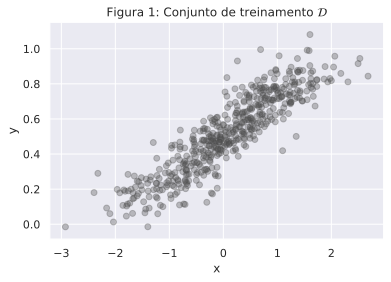

In [4]:
N = 500

train_features = nd.random.normal(loc=0, scale=1, shape=(N, 1))
train_labels = synthetic_data(train_features, func=sigmoid, sigma=0.1)

plt.scatter(train_features.asnumpy(), train_labels.asnumpy(), color=GRAY, alpha=.33)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figura 1: Conjunto de treinamento $\mathcal{D}$');

O código a seguir define uma função chamada `data_iter`. Para `batch_size` igual a um valor $\mathcal{B} \in \mathbb{N}$, ela retorna uma partição aleatória $\mathcal{D}_1, \dots, \mathcal{D}_M$ de $\mathcal{D}$ tal que $|\mathcal{D}_i| = \mathcal{B}$ para $i = 1, \dots, M-1$ e $|\mathcal{D}_M| = N - \mathcal{B}(M - 1)$, onde $M = \lfloor N / \mathcal{B}\rfloor$. Nesse tutorial, só vamos trabalhar com valores de $\mathcal{B}$ que dividem exatamente $N$, de modo que sempre valerá $|\mathcal{D}_M| = \mathcal{B}$.

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)

A seguir, segue um exemplo de utilizaçao de `data_iter`. Note que essa função nos permite acessar as observações de $\mathcal{D}$ em lotes. O tamanho de cada lote é informado à função por meio do parâmetro `batch_size`.

In [6]:
batch_size = 10
for X, y in data_iter(batch_size, train_features, train_labels):
    print(X, y)
    break


[[-0.10481749]
 [-1.8421052 ]
 [ 0.47252357]
 [-0.59778637]
 [-0.12546211]
 [-0.15754144]
 [-0.2624586 ]
 [-0.19339715]
 [-1.2331816 ]
 [-0.7153962 ]]
<NDArray 10x1 @cpu(0)> 
[[0.4275671 ]
 [0.19556478]
 [0.7198767 ]
 [0.3322902 ]
 [0.60780853]
 [0.41004667]
 [0.49895224]
 [0.51883394]
 [0.3760553 ]
 [0.43468866]]
<NDArray 10x1 @cpu(0)>


### Regressão linear clássica

Nesse tutorial, vamos utilizar redes neurais perceptron para executar uma tarefa de regressão. De fato, queremos calcular o valor esperado $\mathbb{E}(y|x)$ da variável contínua $y$ dado que o valor de $x$ é conhecido.

Geralmente, uma rede neural perceptron para uma tarefa de regressão pode ser representada por uma função composta $h:\mathbb{R}^{d} \to \mathbb{R}$ definida por

$$\hat{y} = h(x) = \left(g^{[L]} \circ f^{[L]} \circ \cdots \circ g^{[1]} \circ f^{[1]}\right)(x),$$

onde:
- $x \in \mathbb{R}^d$ é o vetor de entrada;
- $\hat{y} \in \mathbb{R}$ é o valor de saída;
- $L \in \mathbb{N}$ é o número de camadas;
- $f^{[l]}$ é a transformação afim da l-ésima camada, que é definida por $f^{[l]}(x) = xW^{[l]} + b^{[l]}$; e
- $g^{[l]}$ é a função de ativação da l-ésima camada.

Pela Figura 1, é razoável assumir que a relação entre as variáveis $x$ e $y$ é linear. Portanto, podemos usar uma rede neural perceptron de uma única camada e sem função de ativação, isto é, $\hat{y} = h(x) = f^{[1]}(x) = xW^{[l]} + b^{[l]} = xw + b$, para prever o valor de $y$ a partir do valor conhecido de $x$. Nessa nossa primeira rede neural, a entrada e a saída são $x, \hat{y} \in \mathbb{R}$, respectivamente, e os parâmetros são $w, b \in \mathbb{R}$.

Chegamos, assim, ao modelo clássico de regressão linear, que implementaremos a seguir.

In [7]:
def linreg(X, w, b):
    return nd.dot(X, w) + b

### Funções de perda e de custo

Para treinar a rede neural proposta, precisaremos medir quão ruins são as previsões que ela faz. Com efeito, treinar essa rede neural significa tentar encontrar valores para os parâmetros $w$ e $b$ que minimizem o seu erro de previsão.

O papel da função de perda é medir esse erro de previsão para cada observação $\left(x^{(i)}, y^{(i)}\right)$ do conjunto de treinamento $\mathcal{D}$. A primeira função de perda que usaremos nesse tutorial é conhecida como norma L2 e o seu valor para a i-ésima observação de $\mathcal{D}$ é dado por
$$l^{(i)}(w, b) = \left(\hat{y}^{(i)} - y^{(i)}\right)^2 = \left(h\left({x}^{(i)}\right) - y^{(i)}\right)^2 = \left({x}^{(i)}w + b - y^{(i)}\right)^2.$$

O código abaixo define essa função de perda.

In [8]:
def squared_difference(x, y):
    return (x - y) ** 2

A função de custo, por sua vez, expressa o erro de previsão médio da rede neural considerando todo o conjunto de treinamento $\mathcal{D}$ (ou algum dos seus subconjuntos $\mathcal{D}_1, ..., \mathcal{D}_M$):

$$L(w, b) = \frac{1}{N}\sum_{i = 1}^{N}l^{(i)}(w, b) = \frac{1}{N}\sum_{i = 1}^{N}\left({x}^{(i)}w + b - y^{(i)}\right)^2.$$

Nós não vamos implementar a função de custo nesse tutorial. De fato, perceba que ela fica determinada quando nós definimos a função de perda.

### Gradiente descendente

Para essa primeira rede neural, existe uma solução analítica para o problema de encontrar os valores de $w$ e $b$ que minimizam a função de custo $L$. Porém, pensando nas próximas redes neurais que proporemos nesse tutorial, vale a pena definir e utilizar o método do gradiente descendente desde já.

O método do gradiente descendente nos permite encontrar (ou pelo menos obter valores próximos de) um ponto de mínimo local da função de custo $L$. Partindo de valores iniciais $w_0$ e $b_0$, esse método atualiza iterativamente os parâmetros $w$ e $b$, de pouco em pouco e na direção que reduz o valor de $L$, até que algum critério de parada seja satisfeito. Na k-ésima iteração do método, a atualização dependerá apenas dos valores da iteração imediatamente anterior. Supondo que seja $\mathcal{D}_m$ o subconjunto de $\mathcal{D}$ considerado nessa iteração, a atualização ocorrerá da seguinte forma:

$$\left(w^{k}, b^{k}\right) \gets \left(w^{k-1}, b^{k-1}\right) - \frac{\eta}{|\mathcal{D}_m|} \frac{\partial}{\partial \left(w, b\right)} \left[\sum_{i: \left(x^{(i)}, y^{(i)}\right) \in \mathcal{D}_m} l^{(i)}\left(w^{k-1}, b^{k-1}\right)\right],$$

onde $\eta \in \mathbb R_{> 0}$ é a taxa de aprendizagem, o hiperparâmetro do modelo que determina o tamanho das atualizações. 

Quando $M = 1$ ou $1 < M < N$ (lembrando que $M$ é o tamanho da partição aleatória $\mathcal{D}_1, ..., \mathcal{D}_M$ de $\mathcal{D}$), esse método recebe nomes especiais: gradiente descendente estocástico e gradiente descendente em mini-lotes, respectivamente. A escolha apropriada do valor de $M$ nos permite fazer bom uso das memórias e da capacidade de processamento das CPUs e GPUs do nosso computador durante o treinamento da rede neural.

O código a seguir define essa atualização conforme nós acabamos de descrever.

In [9]:
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

### Treinamento

Para treinar a nossa primeira rede neural, executaremos o seguinte procedimento:
- Inicialize os parâmetros $(w, b)$
- Para cada iteração sobre $\mathcal{D}$, faça:
    - Para cada subconjunto $\mathcal{D}_m$ da partição aleatória $\mathcal{D}_1, ..., \mathcal{D}_M$, faça:
        - Calcule o custo $L = |\mathcal{D}_m|^{-1}\sum_i l^{(i)}(w, b)$
        - Calcule o gradiente $\textbf{g} = \partial_{(w, b)} L$
        - Atualize os parâmetros $(w, b) \gets (w, b) - \eta\textbf{g}$

Os dois cálculos do laço interno desse procedimento são feitos automaticamente pela biblioteca `autograd` do MXNet. Só precisamos calcular a perda $l(w, b)$ das observações de $\mathcal{D}_m$.

Para começar, vamos inicializar os parâmetros $w$ e $b$ do nosso modelo. Uma inicialização cuidadosa é importante para assegurar que os gradientes calculados nas primeiras iterações do treinamento não sejam grandes demais ou pequenos demais, evitando os problemas de explosão e desaparecimento de gradientes, muito comuns em redes neurais profundas (que não é nosso caso aqui).

In [10]:
w = nd.random.normal(scale=0.01, shape=(train_features.shape[1], 1))
b = nd.zeros(shape=(1, 1))

Agora vamos reservar espaço na memória para que a biblioteca `autograd` tenha onde armazenar o gradiente de cada parâmetro.

In [11]:
w.attach_grad()
b.attach_grad()

Por fim, vamos executar as iterações do treinamento e, na sequência, gerar um gráfico (Figura 2) contendo as observações e a reta que contém as previsões do nosso modelo.

In [12]:
lr = 0.03
num_epochs = 10 # número de iterações sobre o conjunto de treinamento
batch_size = 50
net = linreg
loss = squared_difference
trainer = sgd

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, train_features, train_labels):
        with autograd.record():
            l = loss(y, net(X, w, b))
        l.backward() # calcula o custo do modelo e o gradiente dos parâmetros
        trainer([w, b], lr, batch_size)
    train_l = loss(train_labels, net(train_features, w, b))
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.091772
epoch 2, loss 0.032368
epoch 3, loss 0.016119
epoch 4, loss 0.011639
epoch 5, loss 0.010401
epoch 6, loss 0.010060
epoch 7, loss 0.009978
epoch 8, loss 0.009947
epoch 9, loss 0.009940
epoch 10, loss 0.009937


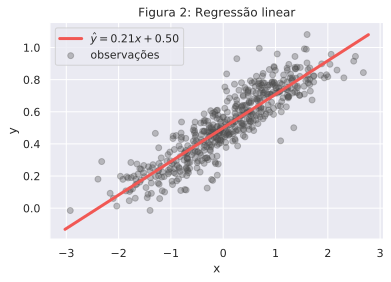

In [13]:
x_min = nd.min(train_features).asscalar() - 0.1
x_max = nd.max(train_features).asscalar() + 0.1
X = nd.arange(x_min, x_max, 0.01).reshape(-1, 1)
yhat = linreg(X, w, b)

plt.scatter(train_features.asnumpy(), train_labels.asnumpy(), color=GRAY, alpha=.33,
            label=r'observações')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figura 2: Regressão linear')

plt.plot(X.asnumpy(), yhat.asnumpy(), lw=3, color=RED, 
         label=r'$\hat{y} = %.2fx + %.2f$' %(w[0].asscalar(), b[0].asscalar()))
plt.legend(loc='upper left');

### Regressão linear probabilística

Seja $\epsilon|x = y - \hat{y} = y -(xw + b)$ o erro de previsão da nossa rede neural. Vamos adicionar uma segunda suposição ao nosso modelo (a primeira é a de linearidade): $\epsilon|x \sim \mathcal{N}(0,\sigma_y^2)$, isto é, $y|x \sim \mathcal{N}(xw + b,\sigma_y^2)$.

Se redefinirmos a função de perda para

$$l^{(i)}(w, b, \sigma_y) = \frac{1}{2}\log(2\pi) + \log(\sigma_y) + \frac{1}{2\sigma_y^2}\left(y^{(i)} - \left(x^{(i)}w + b\right)\right)^2,$$

minimizar a função de custo da rede neural se torna equivalente a maximizar a função de log-verossimilhança do modelo probabilístico definido por

$$y = wx + b + \epsilon.$$

A função de log-verossimilhança expressa quão plausível é uma determinada atribuição de valores para $w$, $b$ e $\sigma_y$ dado o conjunto de treinamento $\mathcal{D}$: supondo que as observações de $\mathcal{D}$ foram geradas por esse modelo, parece verdade que os pesos tenham esses valores?

O código a seguir define essa função.

In [14]:
def softplus(x):
    return nd.log1p(nd.exp(x))

def lognormal(x, loc, scale):
    return (-0.5 * np.log(2. * np.pi) - nd.log(scale)
            -0.5 * squared_difference(x / scale, loc / scale))

def negloglik(x, loc, scale):
    return -lognormal(x, loc, scale)

Nesse exemplo, nossa rede neural passa a ter uma variável aleatória como saída e três parâmetros ao invés de dois. Os parâmetros serão $w$, $b$ e $\rho_y$. Note que usaremos $\rho_y$ ao invés de $\sigma_y$. Definiremos $\sigma_y = \log(1 + \exp(\rho_y))$, donde sempre valerá $\sigma_y > 0$.

In [15]:
w = nd.random.normal(scale=0.01, shape=(train_features.shape[1], 1))
b = nd.zeros(shape=(1, 1))
y_rho = nd.zeros(shape=(1, 1))

In [16]:
w.attach_grad()
b.attach_grad()
y_rho.attach_grad()

Antes de partirmos para o treinamento da nossa segunda rede neural, vamos falar um pouco sobre porque considerar a sua saída $\hat{y}$ como uma variável aleatória com distribuição $\mathcal{N}(xw + b,\sigma_y^2)$. Suponha que o conjunto de treinamento $\mathcal{D}$ contém dados sobre imóveis residenciais vendidos em Belo Horizonte em 2018, no qual $y^{(i)} \in \mathbb{R}$ e $x^{(i)} \in \mathbb{R}^d$ são o valor de venda e o vetor das principais características do i-ésimo imóvel. Suponha também que existem dois imóveis $i$ e $j$ nesse conjunto, com $i \neq j$, tais que $x^{(i)} = x^{(j)}$ (por exemplo, apartamentos vizinhos de um mesmo prédio). Quão certo você está de que observaremos $y^{(i)} = y^{(j)}$?

Essa incerteza é chamada de incerteza aleatória e é intrínseca ao problema em análise. Por exemplo, é impossível representar em $x$ todas as características de um imóvel que podem influenciar o seu preço. Além disso, o processo de compra e venda não é puramente racional e um de seus participantes pode ter mais informações sobre o imóvel do que os outros. Quantificar essa incerteza é importante para estimar um intervalo de confiança em torno das nossas previsões.

A seguir, executaremos o treinamento dessa rede neural conforme descrito anteriormente. Na sequência, vamos mostrar o valor estimado de $\sigma_y$ e gerar um novo gráfico (Figura 3) contendo as observações de $\mathcal{D}$, a reta com as previsões do nosso segundo modelo e um intervalo de confiança para essas previsões.

In [17]:
lr = 0.01
num_epochs = 40
batch_size = 50
net = linreg
loss = negloglik
trainer = sgd

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, train_features, train_labels):
        with autograd.record():
            l = loss(y, net(X, w, b), softplus(y_rho))
        l.backward()
        trainer([w, b, y_rho], lr, batch_size)
    train_l = loss(train_labels, net(train_features, w, b), softplus(y_rho))
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.756123
epoch 2, loss 0.651774
epoch 3, loss 0.562415
epoch 4, loss 0.483226
epoch 5, loss 0.410989
epoch 6, loss 0.343695
epoch 7, loss 0.279856
epoch 8, loss 0.218324
epoch 9, loss 0.157977
epoch 10, loss 0.097949
epoch 11, loss 0.038009
epoch 12, loss -0.022017
epoch 13, loss -0.082179
epoch 14, loss -0.142213
epoch 15, loss -0.201902
epoch 16, loss -0.260925
epoch 17, loss -0.318936
epoch 18, loss -0.375520
epoch 19, loss -0.430310
epoch 20, loss -0.482971
epoch 21, loss -0.532823
epoch 22, loss -0.579784
epoch 23, loss -0.623580
epoch 24, loss -0.663189
epoch 25, loss -0.699163
epoch 26, loss -0.731130
epoch 27, loss -0.756476
epoch 28, loss -0.781349
epoch 29, loss -0.790560
epoch 30, loss -0.821611
epoch 31, loss -0.833852
epoch 32, loss -0.843635
epoch 33, loss -0.856492
epoch 34, loss -0.856502
epoch 35, loss -0.867212
epoch 36, loss -0.871767
epoch 37, loss -0.875656
epoch 38, loss -0.876721
epoch 39, loss -0.816124
epoch 40, loss -0.878572


sigma_y = 0.1068


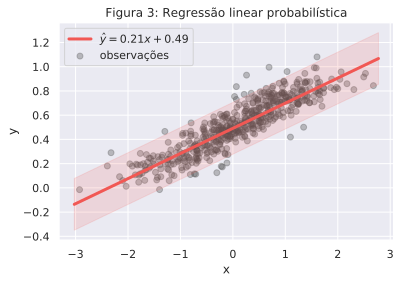

In [18]:
x_min = nd.min(train_features).asscalar() - 0.1
x_max = nd.max(train_features).asscalar() + 0.1
X = nd.arange(x_min, x_max, 0.01).reshape(-1, 1)
yhat = linreg(X, w, b)

plt.scatter(train_features.asnumpy(), train_labels.asnumpy(), color=GRAY, alpha=.33,
            label=r'observações')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figura 3: Regressão linear probabilística')

plt.plot(X.asnumpy(), yhat.asnumpy(), lw=3, color=RED, 
         label=r'$\hat{y} = %.2fx + %.2f$' % (w[0].asscalar(), b[0].asscalar()))

y_sigma = softplus(y_rho)
print('sigma_y = %.4f' % y_sigma[0].asscalar())

y_upper_bound = (yhat + 2 * y_sigma).reshape(-1,)
y_lower_bound = (yhat - 2 * y_sigma).reshape(-1,)
plt.fill_between(X.asnumpy().reshape(-1,), y_upper_bound.asnumpy(), 
                 y_lower_bound.asnumpy(),color=RED, alpha=.15)
plt.legend(loc='upper left');

### Regressão linear bayesiana (RLB)

Existem duas abordagens em aprendizado estatístico: a clássica, também chamada de frequentista, e a bayesiana.

As principais diferenças entre as duas abordagens podem ser resumidas da seguinte forma:
- Na abordagem clássica, probabilidade é o limite de uma frequência relativa. Por exemplo, a probabilidade de se obter cara no lançamento de uma determinada moeda é igual ao limite da proporção de caras obtidas em $n$ lançamentos quando $n \to \infty$. Na abordagem bayesiana, probabilidade expressa grau de crença. Retomando o exemplo da moeda, antes de observar qualquer lançamento, podemos presumir que ela é honesta (pois não temos evidência do contrário, por exemplo), isto é, assumir que a probabilidade de se obter cara em um lançamento é igual a 0.5. Após observar o resultado de uma sequência de lançamentos, nós podemos atualizar a nossa crença sobre essa probabilidade.
- Na abordagem clássica, parâmetros de um modelo são constantes desconhecidas. Como eles não estão sujeitos a variações aleatórias, não associamos probabilidade a eles. Na abordagem bayesiana, parâmetros também são constantes desconhecidas. Porém, nesse caso, podemos atribuir a eles distribuições de probabilidade para a expressar nossa crença de que dados valores dos parâmetros são verdadeiros.

Nesse terceiro exemplo, vamos criar uma rede neural bayesiana. Nela, o vetor de parâmetros $\textbf{w} = (w_1, w_2) = (w, b)$ não será uma constante numérica, mas sim um vetor aleatório, isto é, um vetor de variáveis aleatórias. De forma bem simplificada, faremos o seguinte:
- Escolheremos uma distribuição de probabilidade, que será representada pela sua função de densidade $p(\textbf{w})$, para expressar nosso conhecimento prévio ou nossa crença sobre $\textbf{w}$ antes de observarmos os dados de treinamento $\mathcal{D}$. Esta será a distribuição a priori de $\textbf{w}$.
- Proporemos um modelo probabilístico, com parâmetros $\textbf{w}$ e função de verossimilhança $p(\mathcal{D} \mid \textbf{w}) = p(y \mid x, \textbf{w})$, para exprimir nossa crença sobre um determinado valor de $y$ dados $x$ e $\textbf{w}$.
- Após observarmos $\mathcal{D}$, nós atualizaremos nossa crença sobre $\textbf{w}$ calculando a sua distribuição a posteriori, que será representada pela função de densidade $p(\textbf{w} \mid \mathcal{D})$.

E por que considerar $\textbf{w}$ como um vetor aleatório? Reveja a Figura 1. Quantas retas você poderia traçar que se ajustariam razoavelmente bem aos dados observados? E por que escolher uma e não outra? Suponha que você encontrou a reta que melhor se ajusta às observações de $\mathcal{D}$, ou seja, aquela que produz o menor erro médio de previsão. Ao considerar um outro conjunto de amostras geradas pelo mesmo processo gerador de dados que produziu $\mathcal{D}$, será que essa reta continuaria sendo a melhor? A rede neural bayesiana vai quantificar essa incerteza relacionada aos parâmetros, chamada de incerteza sistemática. Além da incerteza aleatória, como já fizemos no exemplo anterior.

Uma vantagem da rede neural bayesiana é que, dado um valor de $x$, ela não só vai retornar a previsão $\hat{y}$ como também informar quão segura ela está em relação a essa previsão dadas todas as evidências contidas em $\mathcal{D}$ e dadas as nossas suposições de linearidade e normalidade. É razoável esperar, por exemplo, que essa rede não informe muita segurança ao prever $(y \mid x)$ se $x$ está em uma região do espaço de características (*feature space*) que contém nenhuma ou poucas observações de $\mathcal{D}$. E é assim que ela procede. 

Note que, diferentemente da incerteza aleatória, é possível reduzir a incerteza sistemática ao aumentar e diversificar o nosso conjunto de treinamento.

Para começar a definir essa terceira rede neural, vamos assumir que $w_1 = w$ e $w_2 = b$ são variáveis aleatórias independentes e que a priori de $\textbf{w} = (w_1, w_2) = (w, b)$ é uma mistura de duas normais

$$p(\textbf{w}) = p(w_1, w_2) = \prod_{j=1}^{2}p(w_j) = \prod_{j=1}^{2}\pi\mathcal{N}(w_j\mid0, \sigma_1^2) + (1-\pi)\mathcal{N}(w_j\mid0, \sigma_2^2),$$

onde $\pi = 0.5$, $\sigma_1 = 1$ e $\sigma_2 = 0.002$. O código abaixo implementa a função que retorna o logaritmo da densidade dessa mistura.

In [19]:
prior_pi = nd.array([0.5])
prior_sigma1 = nd.array([1.])
prior_sigma2 = nd.array([0.002])

def logmixgaussian(x, pi, scale1, scale2):
    prob1 = nd.exp(lognormal(x, 0, scale1))
    prob2 = nd.exp(lognormal(x, 0, scale2))
    return nd.log(pi * prob1 + (1 - pi) * prob2)

Como é inviável calcular a posteriori $p(\textbf{w} \mid \mathcal{D})$ diretamente (para começar, não sabemos a qual família de distribuições ela pertence), vamos partir de uma família específica de distribuições paramétricas $\mathcal{Q} = \{q(\textbf{w} \mid \theta): \theta \in \Theta\}$ e tentar encontrar $q \in \mathcal{Q}$ que mais se pareça com $p(\textbf{w} \mid \mathcal{D})$.

Dado $\theta \in \Theta$, utilizaremos a divergência de Kullback-Leibler para medir a diferença entre $q(\textbf{w} \mid \theta)$ e $p(\textbf{w} \mid \mathcal{D})$:

$$\begin{equation*}\label{my eq}
\begin{aligned}
  \textbf{KL}[q(\textbf{w} \mid \theta) \mid\mid p(\textbf{w} \mid \mathcal{D})]
    & = \int q(\textbf{w} \mid \theta) \log \frac{q(\textbf{w} \mid \theta)}
        {p(\textbf{w} \mid \mathcal{D})}d\textbf{w}
        &&\text{(por definição)} \\
    & = \int q(\textbf{w} \mid \theta) \log \frac{q(\textbf{w} \mid \theta)p(\mathcal{D})}
        {p(\mathcal{D} \mid \textbf{w})p(\textbf{w})}d\textbf{w}
        &&\text{(pelo Teorema de Bayes)} \\
    & = \int q(\textbf{w} \mid \theta) \log \frac{q(\textbf{w} \mid \theta)}{p(\textbf{w})}
        +\log p(\mathcal{D}) - \log p(\mathcal{D} \mid \textbf{w}) d\textbf{w}
        &&\text{(pelas propriedades de logaritmo)} \\
    & = \int q(\textbf{w} \mid \theta) \log \frac{q(\textbf{w} \mid \theta)}{p(\textbf{w})}
        - \log p(\mathcal{D} \mid \textbf{w}) d\textbf{w}
        + \int q(\textbf{w} \mid \theta) \log p(\mathcal{D}) d\textbf{w}
        &&\text{(pela linearidade da integral)} \\
    & = \int q(\textbf{w} \mid \theta) \log \frac{q(\textbf{w} \mid \theta)}{p(\textbf{w})}
        - \log p(\mathcal{D} \mid \textbf{w}) d\textbf{w}
        + \log p(\mathcal{D}) \int q(\textbf{w} \mid \theta) d\textbf{w}
        &&\text{(pela linearidade da integral)} \\
    & = \int q(\textbf{w} \mid \theta) \log \frac{q(\textbf{w} \mid \theta)}{p(\textbf{w})}
        - \log p(\mathcal{D} \mid \textbf{w}) d\textbf{w}
        + \log p(\mathcal{D})
        &&\text{(pois $q$ é uma função de densidade)} \\
    & = \int q(\textbf{w} \mid \theta) \log \frac{q(\textbf{w} \mid \theta)}{p(\textbf{w})} d\textbf{w}
        - \int q(\textbf{w} \mid \theta) \log p(\mathcal{D} \mid \textbf{w}) d\textbf{w}
        + \log p(\mathcal{D})
        &&\text{(pela linearidade da integral)} \\
    & = \textbf{KL}[q(\textbf{w} \mid \theta) \mid\mid p(\textbf{w})]
        - \mathbb{E}_{\textbf{w} \sim q(\textbf{w} \mid \theta)} [\log p(\mathcal{D} \mid \textbf{w})]
        + \log p(\mathcal{D})
        &&\text{(por definição)} \\
    & \propto \textbf{KL}[q(\textbf{w} \mid \theta) \mid\mid p(\textbf{w})]
        - \mathbb{E}_{\textbf{w} \sim q(\textbf{w} \mid \theta)} [\log p(\mathcal{D} \mid \textbf{w})]
        &&\text{(pois $\log p(\mathcal{D})$ é constante)} \\
\end{aligned}
\end{equation*}$$

Assim, adotaremos como função de custo da nossa rede neural bayesiana a função

$$\mathcal{F}(\mathcal{D}, \theta) = \textbf{KL}[q(\textbf{w} \mid \theta) \mid\mid p(\textbf{w})]
        - \mathbb{E}_{\textbf{w} \sim q(\textbf{w} \mid \theta)} [\log p(\mathcal{D} \mid \textbf{w})],$$

onde o primeiro termo, que não depende dos dados observados $\mathcal{D}$, representa a complexidade (e, portanto, é um regularizador) e o segundo termo representa o valor esperado da log-verossimilhança do modelo.

Usando Monte Carlo, podemos calcular

$$\mathcal{F}(\mathcal{D}, \theta) \approx \frac{1}{T} \sum_{t=1}^{T} \log q(\textbf{w}^{(t)} \mid \theta) - \log p(\textbf{w}^{(t)}) - \log p(\mathcal{D} \mid \textbf{w}^{(t)})$$,

onde $\textbf{w}^{(1)}, \dots, \textbf{w}^{(T)}$ são vetores aleatórios gerados IID da distribuição $q(\textbf{w} \mid \theta)$.

Para obter essa função de custo, basta adotarmos, no nosso procedimento de treinamento, a seguinte função de perda para a i-ésima observação que está no subconjunto $\mathcal{D}_m$ de $\mathcal{D}$:

$$l^{(i)}(\textbf{w}, \sigma_y) = \frac{1}{T} \sum_{t=1}^{T} \{\pi^{(i)}[\log q(\textbf{w}^{(t)} \mid \theta) - \log p(\textbf{w}^{(t)})] - \log p(y^{(i)} \mid x^{(i)}, \sigma_y, \textbf{w}^{(t)})\},$$

onde a log-verossimilhança $\log p(y^{(i)} \mid x^{(i)}, \sigma_y, \textbf{w}^{(t)})$ é a mesma do exemplo anterior e

$$\pi^{(i)} = \frac{2^{M - m}}{\left(2^M - 1\right)\mathcal{B}},$$

conforme sugerido por [1]. Note que o termo de complexidade não depende dos dados observados. Veja também que $\pi^{(1)} + \dots + \pi^{(N)} = 1$ e que quanto menor (maior) o valor de $m$, maior (menor) o peso da complexidade na função de perda.

Como no exemplo anterior, usaremos $\rho_y$ ao invés de $\sigma_y$ e definiremos $\sigma_y = \log(1 + \exp(\rho_y))$, donde sempre valerá $\sigma_y > 0$.

Por fim, adotaremos $\mathcal{Q}$ igual à família das distribuições normais bivariadas com vetor de médias $(\mu_w, \mu_b)$ e matriz de covariância diagonal $(\sigma_w, \sigma_b)$. Nesse caso, os parâmetros da rede passam a ser $\mu_w, \mu_b, \sigma_w$ e $\sigma_b$. Mas usaremos $\rho_w$ e $\rho_b$ ao invés de $\sigma_w$ e $\sigma_b$, respectivamente. Desse modo, para fazer inferências, calcularemos $w = \mu_w + \log(1 + \exp(\rho_w))\epsilon_w$ e $b = \mu_b + \log(1 + \exp(\rho_b))\epsilon_b$, onde $\epsilon_w$ e $\epsilon_b$ são números aleatórios gerados IID de $\mathcal{N}(0, 1)$.

In [20]:
w_mu = nd.zeros(shape=(train_features.shape[1], 1))
w_rho = nd.random.uniform(-5, -4, shape=w_mu.shape)
b_mu = nd.zeros(shape=(1, 1))
b_rho = nd.random.uniform(-5, -4, shape=b_mu.shape)
y_rho = nd.zeros(shape=(1, 1))

In [21]:
w_mu.attach_grad()
w_rho.attach_grad()
b_mu.attach_grad()
b_rho.attach_grad()
y_rho.attach_grad()

A seguir, executaremos o treinamento dessa rede neural conforme já descrito. Na sequência, vamos mostrar o valor estimado de $\sigma_y$ e gerar dois novos gráficos. O primeiro deles (Figura 4) conterá as observações de $\mathcal{D}$, a reta com as previsões e um intervalo de confiança para essas previsões considerando apenas a incerteza sistemática. No segundo deles (Figura 5), o intervalo de confiança considerará tanto a incerteza sistemática quanto a incerteza aleatória.

In [22]:
lr = 0.01
num_epochs = 50
batch_size = 50
num_samples = 5
net = linreg

num_batches = N / batch_size
for epoch in range(num_epochs):
    batch_idx = 0
    for X, y in data_iter(batch_size, train_features, train_labels):
        batch_idx = batch_idx + 1
        with autograd.record():
            w_eps = nd.random.normal(shape=(w_rho.shape[0], num_samples))
            w = w_mu + softplus(w_rho) * w_eps
            b_eps = nd.random.normal(shape=(1, num_samples))
            b = b_mu + softplus(b_rho) * b_eps
            outputs = net(X, w, b)
            yhat = outputs.mean(1, keepdims=True)
            negative_log_likelihood = negloglik(y, yhat, softplus(y_rho))
            log_priors = (logmixgaussian(w, prior_pi, prior_sigma1, prior_sigma2).sum(0, keepdims=True) 
                          + logmixgaussian(b, prior_pi, prior_sigma1, prior_sigma2))
            log_prior = log_priors.mean()
            log_variational_posteriors = (lognormal(w, w_mu, softplus(w_rho)).sum(0, keepdims=True) 
                                          + lognormal(b, b_mu, softplus(b_rho)))
            log_variational_posterior = log_variational_posteriors.mean()
            pi = (2 ** (num_batches - batch_idx)) / (2 ** num_batches - 1)
            l = (pi * (log_variational_posterior - log_prior) / batch_size 
                 + negative_log_likelihood)
        l.backward()
        trainer([w_mu, w_rho, b_mu, b_rho, y_rho], lr, batch_size)
    train_l = negloglik(train_labels, net(train_features, w_mu, b_mu), softplus(y_rho))
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.730629
epoch 2, loss 0.632133
epoch 3, loss 0.546597
epoch 4, loss 0.469705
epoch 5, loss 0.399290
epoch 6, loss 0.333168
epoch 7, loss 0.270256
epoch 8, loss 0.208934
epoch 9, loss 0.148592
epoch 10, loss 0.088680
epoch 11, loss 0.028758
epoch 12, loss -0.031284
epoch 13, loss -0.091436
epoch 14, loss -0.151408
epoch 15, loss -0.211096
epoch 16, loss -0.269856
epoch 17, loss -0.327620
epoch 18, loss -0.383836
epoch 19, loss -0.438267
epoch 20, loss -0.490518
epoch 21, loss -0.539577
epoch 22, loss -0.586423
epoch 23, loss -0.629174
epoch 24, loss -0.667376
epoch 25, loss -0.704625
epoch 26, loss -0.735352
epoch 27, loss -0.763959
epoch 28, loss -0.786806
epoch 29, loss -0.803772
epoch 30, loss -0.820354
epoch 31, loss -0.834726
epoch 32, loss -0.845488
epoch 33, loss -0.852070
epoch 34, loss -0.863989
epoch 35, loss -0.863593
epoch 36, loss -0.852583
epoch 37, loss -0.867576
epoch 38, loss -0.875372
epoch 39, loss -0.855874
epoch 40, loss -0.880102
epoch 41, loss -0.86

sigma_y = 0.1027


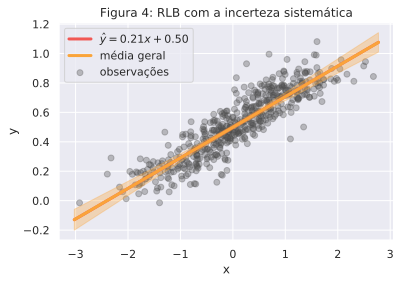

In [23]:
x_min = nd.min(train_features).asscalar() - 0.1
x_max = nd.max(train_features).asscalar() + 0.1
X = nd.arange(x_min, x_max, 0.01).reshape(-1, 1)
yhat = linreg(X, w_mu, b_mu)

plt.scatter(train_features.asnumpy(), train_labels.asnumpy(), color=GRAY, alpha=.33,
            label=r'observações')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figura 4: RLB com a incerteza sistemática')

plt.plot(X.asnumpy(), yhat.asnumpy(), lw=3, color=RED, 
         label=r'$\hat{y} = %.2fx + %.2f$' % (w_mu[0].asscalar(), b_mu[0].asscalar()))

num_samples = 10000

w_eps = nd.random.normal(shape=(w_rho.shape[0], num_samples))
w = w_mu + softplus(w_rho) * w_eps
b_eps = nd.random.normal(shape=(1, num_samples))
b = b_mu + softplus(b_rho) * b_eps
yhats = linreg(X, w, b).asnumpy()

avgm = np.mean(yhats, 1)
plt.plot(X.asnumpy(), avgm, lw=3, color=ORANGE, label=r'média geral')

y_sigma = softplus(y_rho)
print('sigma_y = %.4f' % y_sigma[0].asscalar())

PI = np.quantile(yhats, [0.025, 0.975], axis=1)
y_upper_bound = PI[1, :]
y_lower_bound = PI[0, :]
plt.fill_between(X.asnumpy().reshape(-1,), y_upper_bound, 
                 y_lower_bound,color=ORANGE, alpha=.33)
plt.legend(loc='upper left');

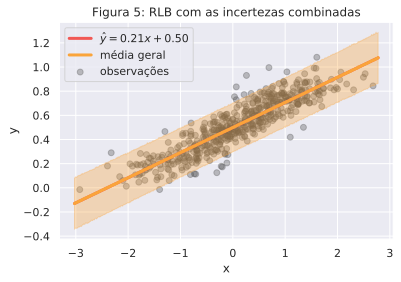

In [24]:
plt.scatter(train_features.asnumpy(), train_labels.asnumpy(), color=GRAY, alpha=.33,
            label=r'observações')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figura 5: RLB com as incertezas combinadas')

plt.plot(X.asnumpy(), yhat.asnumpy(), lw=3, color=RED, 
         label=r'$\hat{y} = %.2fx + %.2f$' % (w_mu[0].asscalar(), b_mu[0].asscalar()))

y_eps = nd.random.normal(shape=(X.shape[0], num_samples))
yhats = (linreg(X, w, b) + softplus(y_rho) * y_eps).asnumpy()

avgm = np.mean(yhats, 1)
plt.plot(X.asnumpy(), avgm, lw=3, color=ORANGE, label=r'média geral')

PI = np.quantile(yhats, [0.025, 0.975], axis=1)
y_upper_bound = PI[1, :]
y_lower_bound = PI[0, :]
plt.fill_between(X.asnumpy().reshape(-1,), y_upper_bound, 
                 y_lower_bound,color=ORANGE, alpha=.33)
plt.legend(loc='upper left');

### Referências

[1] Charles Blundell, Julien Cornebise, Koray Kavukcuoglu, and Daan Wierstra. Weight uncertainty in neural networks. *arXiv preprint arXiv:1505.05424*, 2015.

[2] Larry Wasserman. All of statistics: a concise course in statistical inference, Springer Science+Business Media, Inc., 2004.

[3] Aston Zhang, Zachary C. Lipton, Mu Li, Alexander J. Smola. Dive into Deep Learning. 2019. Disponível em: <http://www.d2l.ai>.